In [1]:
import sys
sys.path.append('sam_road')
sys.path.append('road_extract')
print (sys.path)
import json
import argparse
import sam_road.SAM_ROAD as sam_road
import sam_box.SAM_box as sam

import road_extract.road_extraction as road_ex

import matplotlib.pyplot as plt
import cv2

from skimage import measure
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime
import os

import base64
import pickle
import shapely
import rasterio
from rasterio.features import geometry_mask
#data clearning

['/home/kt/python/RemoteSeg', '/home/kt/anaconda3/envs/SAM/lib/python310.zip', '/home/kt/anaconda3/envs/SAM/lib/python3.10', '/home/kt/anaconda3/envs/SAM/lib/python3.10/lib-dynload', '', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/mmpose-0.28.0-py3.10.egg', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/xtcocotools-1.14.3-py3.10-linux-x86_64.egg', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/munkres-1.1.4-py3.10.egg', '/home/kt/python/Grounded-Segment-Anything/recognize-anything', '/home/kt/python/Grounded-Segment-Anything/segment_anything', '/home/kt/anaconda3/envs/SAM/lib/python3.10/site-packages/setuptools/_vendor', 'sam_road', 'road_extract']


In [ ]:
def resize_to_square_and_pad(image_source, scale):
    """
    Resize the image to a square with dimensions divisible by 256,
    then resize it by dividing dimensions by the given scale and add padding.

    Parameters:
        image_source (numpy.ndarray): The input image.
        scale (int): The scaling divisor (e.g., 1, 2, 4, 8, ...).

    Returns:
        numpy.ndarray: The resized, squared, and padded image.
    """
    # Original dimensions
    original_height, original_width = image_source.shape[:2]
    
    # Calculate the next multiple of 256 for the larger dimension
    max_dim = max(original_height, original_width)
    square_dim = ((max_dim + 255) // 256) * 256  # Round up to the nearest multiple of 256

    # Resize the image to square dimensions
    resized_to_square = cv2.resize(image_source, (square_dim, square_dim), interpolation=cv2.INTER_AREA)
    
    # Compute scaled dimensions
    new_dim = max(1, square_dim // scale)

    # Resize the square image by the given scale
    resized_image = cv2.resize(resized_to_square, (new_dim, new_dim), interpolation=cv2.INTER_AREA)

    # Calculate padding to restore the image to the original square dimensions
    delta_width = square_dim - new_dim
    delta_height = square_dim - new_dim

    top = delta_height // 2
    bottom = delta_height - top
    left = delta_width // 2
    right = delta_width - left

    # Add padding
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

def remove_padding_and_resize(image_padded, original_size):
    """
    Remove padding from an image and resize it back to its original size.

    Parameters:
        image_padded (numpy.ndarray): The padded image.
        original_size (tuple): The original size of the image (height, width).

    Returns:
        numpy.ndarray: The image resized back to its original size.
    """
    # Identify the non-zero region (content without padding)
    gray_image = cv2.cvtColor(image_padded, cv2.COLOR_BGR2GRAY) if len(image_padded.shape) == 3 else image_padded
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    x, y, w, h = cv2.boundingRect(binary_mask)

    # Crop the region of interest (ROI) without padding
    cropped_image = image_padded[y:y+h, x:x+w]

    # Resize back to the original size
    resized_to_original = cv2.resize(cropped_image, (original_size[1], original_size[0]), interpolation=cv2.INTER_AREA)

    return resized_to_original

def combine_multiscale_results(scale_results, original_size, method='average'):
    """
    Combine multi-scale results into a single result.

    Parameters:
        scale_results (list): A list of results (masks or probability maps) at different scales.
        original_size (tuple): The original size of the image (height, width).
        method (str): Combination method - 'average' or 'max'.

    Returns:
        numpy.ndarray: The combined result resized to the original image size.
    """
    combined_result = np.zeros(original_size, dtype=np.float32)

    for result in scale_results:
        # Resize each result back to the original size
        resized_result = cv2.resize(result, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)
        
        # Combine the results based on the selected method
        if method == 'average':
            combined_result += resized_result
        elif method == 'max':
            combined_result = np.maximum(combined_result, resized_result)
        else:
            raise ValueError("Invalid method. Use 'average' or 'max'.")

    # For averaging, divide by the number of scales
    if method == 'average':
        combined_result /= len(scale_results)

    # Normalize the result if necessary
    combined_result = np.clip(combined_result, 0, 255).astype(np.uint8)
    return combined_result

def combine_multiscale_results(scale_results, scales, original_size, method='average'):
 
    combined_result = np.zeros(original_size, dtype=np.float32)

    for idx, (result, scale) in enumerate(zip(scale_results, scales)):
        print(f"Processing scale {scale} - result shape: {result.shape}")

        # Step 1: Reverse padding to restore to square resolution (if padding was added)
        target_size = (int(original_size[1] * scale), int(original_size[0] * scale))
        if result.shape[:2] != target_size:
            print(f"Resizing result {idx} to {target_size}")
            result = cv2.resize(result, target_size, interpolation=cv2.INTER_LINEAR)
        
        # Step 2: Resize result back to the original image size
        resized_result = cv2.resize(result, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)

        # Step 3: Combine results
        if method == 'average':
            combined_result += resized_result
        elif method == 'max':
            combined_result = np.maximum(combined_result, resized_result)
        else:
            raise ValueError("Invalid method. Use 'average' or 'max'.")

    # Normalize results
    if method == 'average':
        combined_result /= len(scale_results)

    # Clip the results to ensure valid range (e.g., for masks)
    combined_result = np.clip(combined_result, 0, 255).astype(np.uint8)
    return combined_result

In [ ]:
def generate_segmentation_MAID():
    m_aid_dir = ""
    return

def read_detection_json(json_path):
    file_json = open(json_path)
    json_obj = json.load(file_json)
    data_json = json_obj['data']

    return data_json

# def create_sub_masks(mask_image, width, height):
#     # Initialize a dictionary of sub-masks indexed by RGB colors
#     sub_masks = {}
#     for x in range(width):
#         for y in range(height):
#             # Get the RGB values of the pixel
#             pixel = mask_image.getpixel((x, y))[:3]

#             # Check to see if we have created a sub-mask...
#             pixel_str = str(pixel)
#             sub_mask = sub_masks.get(pixel_str)
#             if sub_mask is None:
#                 # Create a sub-mask (one bit per pixel) and add to the dictionary
#                 # Note: we add 1 pixel of padding in each direction
#                 # because the contours module doesn"t handle cases
#                 # where pixels bleed to the edge of the image
#                 sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

#             # Set the pixel value to 1 (default is 0), accounting for padding
#             sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

#     return sub_masks

# def create_sub_masks(mask_array, width, height):
#     """
#     Create sub-masks from a numpy array representation of a mask.
    
#     Args:
#         mask_array (numpy.ndarray): The input mask as a NumPy array. Can be grayscale (2D) or RGB (3D).
#         width (int): The width of the mask.
#         height (int): The height of the mask.

#     Returns:
#         dict: A dictionary where keys are unique values (or RGB tuples for RGB images),
#               and values are binary NumPy arrays (sub-masks).
#     """
#     # Initialize a dictionary of sub-masks
#     sub_masks = {}
    
#     # Check if the mask is grayscale (2D) or RGB (3D)
#     if mask_array.ndim == 2:
#         # Grayscale: Extract unique values
#         unique_values = np.unique(mask_array)
#         for value in unique_values:
#             # Create a binary mask for the current value
#             color_mask = (mask_array == value)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(value)] = padded_mask.astype(np.uint8)
#     elif mask_array.ndim == 3:
#         # RGB: Extract unique RGB values
#         unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
#         for color in unique_colors:
#             # Create a binary mask for the current color
#             color_mask = np.all(mask_array == color, axis=-1)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(tuple(color))] = padded_mask.astype(np.uint8)
#     else:
#         raise ValueError("mask_array must be either 2D (grayscale) or 3D (RGB).")

#     return sub_masks

# def create_sub_mask_annotation(sub_mask):
#     # Find contours (boundary lines) around each sub-mask
#     # Note: there could be multiple contours if the object
#     # is partially occluded. (E.g. an elephant behind a tree)
#     contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

#     polygons = []
#     segmentations = []
#     number = 0
#     for contour in contours:
#         # Flip from (row, col) representation to (x, y)
#         # and subtract the padding pixel
#         for i in range(len(contour)):
#             row, col = contour[i]
#             contour[i] = (col - 1, row - 1)

#         # if number == 94:
#         #     test = 1
#         # Make a polygon and simplify it
#         poly = Polygon(contour)
#         poly = poly.simplify(1.0, preserve_topology=False)

#         if (poly.is_empty):
#             # Go to next iteration, dont save empty values in list
#             continue

#         polygons.append(poly)

#         if isinstance(poly, MultiPolygon):
#             # Handle multiple Polygons
#             # print("Result is a MultiPolygon:")
#             for i, sub_poly in enumerate(poly.geoms):
#                 segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
#                 segmentations.append(segmentation)
#         elif isinstance(poly, Polygon):
#             segmentation = np.array(poly.exterior.coords).ravel().tolist()
#             segmentations.append(segmentation)
#         # number = number + 1
#         # print(poly)
#         # print(number)

#     return polygons, segmentations

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x, y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
                # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

    return sub_masks


def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    number = 0
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # if number == 94:
        #     test = 1
        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if (poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        if isinstance(poly, MultiPolygon):
            # Handle multiple Polygons
            # print("Result is a MultiPolygon:")
            for i, sub_poly in enumerate(poly.geoms):
                segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
                segmentations.append(segmentation)
        elif isinstance(poly, Polygon):
            segmentation = np.array(poly.exterior.coords).ravel().tolist()
            segmentations.append(segmentation)
        # number = number + 1
        # print(poly)
        # print(number)

    return polygons, segmentations


def generate_segmentation(args):

    #create df
    # Define the column names
    columns = ["image_path", "class", "roi", "dice","path"]
    # Create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=columns)
    
    #load models
    config_dir = "sam_road/config/"
    sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
    net_cityscale, config_cityscale = sam_road.load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
    net_spacenet, config_spacenet = sam_road.load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")
    
    index = 23
    data_jsons = read_detection_json(args.json_path)[index:index+1]

    for data_json in data_jsons:
        ##NEED remove
        label = data_json['object_annotations'][0]['label']
        ###########
        image_sources, main_images, gt_images, dice_lists, box_lists, roi_mask_lists, local_image_paths, label_box_list, overlay_box_list = sam.sementation_call(data_json, args.data_path)
        
        
        
        for box_roi, dice_result, label_box, overlay_box in zip(box_lists[0],dice_lists[0],label_box_list, overlay_box_list):
            
            sam_box_dir = "/home/datadisk/pipe/results/sam_box/"
            save_folder = local_image_paths[0].split("/")[-1].split(".")[0]
            if not os.path.exists(sam_box_dir+save_folder):
                # Create the directory
                os.makedirs(sam_box_dir+save_folder)
            
            box_final_path = sam_box_dir+save_folder+"/"+label_box+'_'+datetime.now().strftime('%Y%m%d%H%M%S%f')+".jpg"
            cv2.imwrite(box_final_path, overlay_box)
            
            new_row = {"image_path": local_image_paths[0], "class": label_box, "roi": box_roi, "dice": dice_result, "path":box_final_path}
            df = df.append(new_row, ignore_index=True)
                
        image_name = data_json['image'][0].split("/")[-1]
        cv2.imwrite('/home/kt/segment_tmp/'+label+'_'+image_name,main_images[0])


        #print(roi_mask_lists)
        for image_source, main_image, local_image_path in zip(image_sources,main_images, local_image_paths):

            image_sourceCopy = image_source.copy()
            original_height, original_width = image_source.shape[:2]
            if original_height <256 or original_width <256:
                new_height = 256
                new_width = 256

                # Resize the image
                resized_image = cv2.resize(image_source, (new_width, new_height), interpolation=cv2.INTER_AREA)
                image_source = resized_image
#             print ("image shape: ",image_source.shape)



#             plt.imshow(main_image)
#             plt.show()

            ##ALL about road
            if (False):
                #road #1
                multi_scales = [1,2,3,4]
                scale_results = []
                scale_results_small = []
                for scale in multi_scales:
                    #print ("scale:", scale)
                    padded_image = resize_to_square_and_pad(image_source, scale)
                    plt.imshow(padded_image)
                    plt.show()
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, padded_image, config_spacenet)


                    overlay_image = sam_road.overlay_mask_on_image(padded_image, road_mask_spacenet, color=(0, 255, 0), alpha=0.2,th=15)

                    final_over = remove_padding_and_resize(overlay_image, image_source.shape)
                    final_scale_result = remove_padding_and_resize(road_mask_spacenet, image_source.shape)
                    scale_results.append(final_scale_result)

        #             plt.imshow(final_over)
        #             plt.show()

                    padded_image
                    img = cv2.resize(image_source,(1024,1024))
                    padded_image = resize_to_square_and_pad(img, scale)
                    mask, blended_image = road_ex.road_extraction_image(padded_image)

                    final_scale_result = remove_padding_and_resize(blended_image, img.shape)
                    scale_results_small.append(final_scale_result)
        #             plt.imshow(final_scale_result)
        #             plt.show()

                #combined_mask = combine_multiscale_results(scale_results, main_image.shape[:2], method='average')
                combined_mask = combine_multiscale_results(scale_results,multi_scales, main_image.shape[:2], method='average')
                combined_mask_small = combine_multiscale_results(scale_results_small,multi_scales, (1024,1024,3), method='average')
                overlay_image = sam_road.overlay_mask_on_image(main_image, combined_mask, color=(0, 255, 255), alpha=0.2,th=25)

                plt.imshow(overlay_image)
                plt.show()

                threshold = 25

                binary_mask = (combined_mask > threshold).astype(int)

        #         sub_mask = create_sub_masks(binary_mask,binary_mask.shape[1],binary_mask.shape[0])
        #         print (sub_mask)
                polygons, segmentations = create_sub_mask_annotation(binary_mask)

                #print (segmentations)
                
                print ('Sam TH:',threshold)
                plt.imshow(binary_mask)
                plt.show()      
                
                
                print ('sam')
                try:
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, image_sourceCopy, config_spacenet)
                    overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=15)
                    plt.imshow(overlay_image)
                    plt.show()
                except:
                    print ('Error size need resize')
                
                print ('combined_mask_small combine')
                plt.imshow(combined_mask_small)
                plt.show()


                #road #2
                print ('combined_mask_small single')
                mask, blended_image = road_ex.road_extraction(local_image_path)
                plt.imshow(blended_image)
                plt.show()
                
    return df
                



parser = argparse.ArgumentParser()
parser.add_argument("--json-path", type=str, default="")
parser.add_argument("--data-path", type=str, default="/goss/Datasets/")
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/DOTA2.0/Annotations_train_hbb.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/million-AID/train_80_percent.json"]
sys.argv = ['test','--json-path', "/datadisk2/JSON/new_format/dataset2_JSON/iSAID/Annotations_val.json"]




#sys.argv = ['test','--json-path', 'hbb_detection_toyset.json']
#sys.argv = ['test','--json-path', "[PIX_SEG]BH-Pools_Watertanks_Datasets_Annotations_test.json"] 


args = parser.parse_args()

# Use the parsed arguments


df = generate_segmentation(args)


df.to_csv('/home/datadisk/pipe/results/sam_box/output.csv', index=False)
#read_detection_json(args)
print(f"json_path: {args.json_path}")

In [ ]:
df1 = pd.read_csv("/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_4523_v2/output.csv")#'/home/datadisk/pipe/results/sam_box/output.csv')
df1['dataset'] = df1['image_path'].str.split('/').str[3]

df = df1
df

In [ ]:
df1 = df
df1.drop(df1[df1['box_area'] <50].index, inplace=True)
result_small = df1.groupby('dataset')['dice'].agg(['mean', 'std', 'count'])
result_small

In [ ]:
df

In [ ]:
import pandas as pd

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Show full content of each cell


# Assuming your DataFrame is named df
# Group by the 'class' column and calculate the mean and std for the 'dice' column
result = df.groupby('class')['dice'].agg(['mean', 'std'])

# Reset the index to make 'class' a column again (optional)
result = result.reset_index()

focus_class = ['airplane', 'airport', 'baseball field', 'basketball court', 'bridge', 'chimney', 'crane', 'dam', 'expressway service area', 'expressway toll station', 'golf field', 'ground track field', 'harbor', 'helicopter', 'helipad', 'overpass', 'pylon', 'railway station', 'roundabout', 'ship', 'soccer ball field', 'stadium', 'storage tank', 'swimming pool', 'tennis court', 'vehicle', 'windmill']


result = result[result['class'].isin(focus_class)]#.sort_values(by='mean', ascending=False)
result

(result)

In [ ]:
len(list(df["class"].unique()))

In [ ]:
list(df['path'])

In [ ]:
len(list(df['image_path'].unique()))

In [ ]:
df = df1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Example DataFrame
# data = {
#     "image_path": ["image1.jpg", "image1.jpg", "image2.jpg", "image2.jpg", "image3.jpg"],
#     "class": ["cat", "dog", "cat", "bird", "dog"],
#     "roi": ["100,200,300,400", "150,250,350,450", "200,300,400,500", "250,350,450,550", "300,400,500,600"],
#     "dice": [0.85, 0.90, 0.78, 0.88, 0.92],
#     "path": ["path1", "path1", "path2", "path2", "path3"]
# }

# df = pd.DataFrame(data)

# Set the style for Seaborn
sns.set(style="whitegrid")

# 1. Dice Coefficient Distribution by Class
plt.figure(figsize=(8, 6))
sns.boxplot(x="class", y="dice", data=df)
plt.title("Dice Coefficient Distribution by Class")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Dice Coefficient")
plt.show()

# 2. Average Dice Coefficient per Class
avg_dice_per_class = df.groupby("class")["dice"].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x="class", y="dice", data=avg_dice_per_class)
plt.title("Average Dice Coefficient per Class")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Average Dice Coefficient")
plt.show()

# # 3. Dice Coefficient per Image
# plt.figure(figsize=(10, 6))
# sns.barplot(x="image_path", y="dice", hue="class", data=df)
# plt.title("Dice Coefficient per Image")
# plt.xlabel("Image Path")
# plt.xticks(rotation=90)
# plt.ylabel("Dice Coefficient")
# plt.legend(title="Class")
# plt.show()

# 4. Class Frequency
class_freq = df["class"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_freq.index, y=class_freq.values)
plt.title("Class Frequency")

plt.xlabel("Class")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()

In [ ]:
import ast

# Convert ROI from string to list of integers
try:
    df["roi"] = df["roi"].apply(lambda x: list(map(float, x)))
except:
    df["roi"] = df["roi"].apply(lambda x: list(map(float, ast.literal_eval(x))))

# Add width and height columns
df["width"] = df["roi"].apply(lambda x: x[2]-x[0])
df["height"] = df["roi"].apply(lambda x: x[3]-x[1])

# Add bounding box size category (small, medium, large)
def get_box_size_category(width, height):
    area = width * height
    if area < 120:  # Small box
        return "1. small(120px)"
    elif area < 500:  # Medium box
        return "2. medium (500px)"
    elif area < 750:  # Medium box
        return "3. medium-large (750px)"
    elif area < 1000:  # Medium box
        return "4. large (1000px)"
    else:  # Large box
        return "5. Huge(>1000px)"

df["box_size"] = df.apply(lambda row: get_box_size_category(row["width"], row["height"]), axis=1)

# Set the style for Seaborn
sns.set(style="whitegrid")


# 2. Dice Coefficient Distribution by Box Size
plt.figure(figsize=(8, 6))
sns.boxplot(x="box_size", y="dice", data=df)
plt.title("Dice Coefficient Distribution by Box Size")
plt.xlabel("Box Size")
plt.xticks(rotation=90)
plt.ylabel("Dice Coefficient")
plt.show()

# 3. Average Dice Coefficient per Box Size
avg_dice_per_box_size = df.groupby("box_size")["dice"].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x="box_size", y="dice", data=avg_dice_per_box_size)
plt.title("Average Dice Coefficient per Box Size")
plt.xlabel("Box Size")
plt.xticks(rotation=90)
plt.ylabel("Average Dice Coefficient")
plt.show()

# 4. Scatter Plot of Dice vs. Bounding Box Area

df["box_area"] = df["width"] * df["height"]
# removed_outliers = df[df['box_area'] <= 2000]
# df = removed_outliers

for class_name in list(df['class'].unique()):
    new_df = df.loc[df['class'] == class_name]
    print (new_df.describe())
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="box_area", y="dice", hue="class", data=new_df)
    plt.title("Dice Coefficient vs. Bounding Box Area")
    plt.xlabel("Bounding Box Area")
    plt.xticks(rotation=90)
    plt.ylabel("Dice Coefficient")
    plt.legend(title="Class")
    plt.show()
    
    
    
    avg_dice_per_box_size = new_df.groupby("box_size")["dice"].mean().reset_index()
    plt.figure(figsize=(8, 6))
    sns.barplot(x="box_size", y="dice", data=avg_dice_per_box_size)
    plt.title(f"Average Dice Coefficient {class_name} per Box Size")
    plt.xlabel("Box Size")
    plt.xticks(rotation=90)
    plt.ylabel("Average Dice Coefficient")
    plt.show()



In [ ]:
df

In [ ]:
class_list_index = list(df['class'].unique())

In [ ]:
import matplotlib.image as img
# reading the image
class_idx = 0
class_df = df.loc[df['class'] == 'expressway service area']#class_list_index[class_idx]]
index = 20
print (class_list_index[class_idx])
for hel,dice in zip(list(class_df['path'])[index:index+10],list(class_df['dice'])[index:index+10]):
    testImage = img.imread(hel)
    
    print ('DICE:', dice)
    # displaying the image
    plt.imshow(testImage)
    plt.show()

In [ ]:
from skimage import segmentation

In [ ]:
df.loc[20]['image_path']

In [ ]:

x1, y1, x2, y2 = df.loc[0]['roi']
x1

In [ ]:
img =cv2.imread(df.loc[20]['image_path'])

slic = segmentation.slic(img, n_segments=2000, compactness=10, max_num_iter=20, start_label=1)

In [ ]:
fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax3 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax3.imshow(segmentation.mark_boundaries(img, slic))
ax3.set_title('SLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np

# Load the full image and mask image
load_index = 4400

print (df.loc[load_index]['class'], df.loc[load_index]['dice'])
img = cv2.imread(df.loc[load_index]['image_path']) 
full_image = cv2.imread(df.loc[load_index]['image_path'])  
mask_image = cv2.imread(df.loc[load_index]['path'], cv2.IMREAD_GRAYSCALE)  

# Define the ROI coordinates [x1, y1, x2, y2]
# x1, y1, x2, y2 = df.loc[load_index]['roi'].replace('[',"").replace(']','').split(',')
# x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
x1, y1, x2, y2 = df.loc[load_index]['roi']
# Extract the ROI from the full image
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
roi = full_image[y1:y2, x1:x2]
mask_resized = cv2.resize(mask_image, (roi.shape[1], roi.shape[0]))
_, binary_mask = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)
overlay_color = [0, 255, 0]  # Green color for the mask
mask_indices = binary_mask == 255
roi[mask_indices] = overlay_color

# Place the modified ROI back into the full image
full_image[y1:y2, x1:x2] = roi


fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax3 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax3.imshow(full_image)
ax3.set_title('mask')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np

# Load the full image and mask image
load_index = 1

print (df.loc[load_index]['class'], df.loc[load_index]['dice'])

img = cv2.imread(df.loc[load_index]['image_path']) 
full_image = cv2.imread(df.loc[load_index]['image_path'])  
gt_mask = cv2.imread(df.loc[load_index]['gt_path'].replace('/toy_set/','/toy_set_sample/'), cv2.IMREAD_GRAYSCALE)  
#gt_mask = cv2.imread("/home/datadisk/pipe/results/sam_box/toy_set/segmentation_toyset_5414/3188/agriculture area_20250304140048100915_gt.jpg", cv2.IMREAD_GRAYSCALE)  


pred_mask = cv2.imread(df.loc[load_index]['path'].replace('/toy_set/','/toy_set_sample/'), cv2.IMREAD_GRAYSCALE)  

# Define the ROI coordinates [x1, y1, x2, y2]
x1, y1, x2, y2 = df.loc[load_index]['roi']

# Extract the ROI from the full image
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
roi = full_image[y1:y2, x1:x2]

# Resize the GT mask and predicted mask to match the ROI size
gt_mask_resized = cv2.resize(gt_mask, (roi.shape[1], roi.shape[0]))
pred_mask_resized = cv2.resize(pred_mask, (roi.shape[1], roi.shape[0]))

# Create binary masks (if not already binary)
_, gt_binary = cv2.threshold(gt_mask_resized, 127, 255, cv2.THRESH_BINARY)
_, pred_binary = cv2.threshold(pred_mask_resized, 127, 255, cv2.THRESH_BINARY)

# Compare the GT and predicted masks
correct_segmentation = np.logical_and(gt_binary == 255, pred_binary == 255)  # Green
over_segmentation = np.logical_and(gt_binary == 255, pred_binary == 0)      # Red
under_segmentation = np.logical_and(gt_binary == 0, pred_binary == 255)     # Blue

# Overlay the colors on the ROI
roi[correct_segmentation] = [0, 255, 0]  # Green for correct segmentation
roi[over_segmentation] = [0, 0, 255]     # Red for over-segmentation
roi[under_segmentation] = [255, 0, 0]    # Blue for under-segmentation

# Place the modified ROI back into the full image
full_image[y1:y2, x1:x2] = roi

fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax3 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax3.imshow(full_image)
ax3.set_title('mask')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
df.loc[load_index]['image_path']

In [ ]:



def polygon2mask(multi_polygon,height,width):
    # 定义掩码的尺寸和变换
    height, width = height, width  # 掩码的高度和宽度
    transform = rasterio.transform.from_origin(0, height, 1, 1)  # 定义地理变换

    # 将 MultiPolygon 转换为掩码
    mask = geometry_mask(
        [multi_polygon],  # 需要转换的几何对象
        transform=transform,  # 地理变换
        out_shape=(height, width),  # 掩码的尺寸
        invert=True  # 如果为 True，则多边形内部为 True，外部为 False
    )
    return mask

def str2object(json_string):
    # 把str反序列化成对象
    pickled_bytes = base64.b64decode(json_string.encode("utf-8"))
    obj = pickle.loads(pickled_bytes)
    return obj

ooobj = (str2object('gASV+wgAAAAAAACMCnNoYXBlbHkuaW+UjAhmcm9tX3drYpSTlELWCAAAAQYAAAABAAAAAQMAAAABAAAAjAAAAAAAAAAAuJNAAAAAAAA0k0AAAAAAALiTQAAAAAAAOJNAAAAAAAC4k0AAAAAAADyTQAAAAAAAuJNAAAAAAABAk0AAAAAAALiTQAAAAAAARJNAAAAAAAC4k0AAAAAAAEiTQAAAAAAAuJNAAAAAAABMk0AAAAAAALiTQAAAAAAAUJNAAAAAAAC4k0AAAAAAAFSTQAAAAAAAuJNAAAAAAABYk0AAAAAAALiTQAAAAAAAXJNAAAAAAAC4k0AAAAAAAGCTQAAAAAAAuJNAAAAAAABkk0AAAAAAALSTQAAAAAAAaJNAAAAAAACwk0AAAAAAAGyTQAAAAAAArJNAAAAAAABsk0AAAAAAAKiTQAAAAAAAcJNAAAAAAACkk0AAAAAAAHSTQAAAAAAAoJNAAAAAAAB4k0AAAAAAAJyTQAAAAAAAeJNAAAAAAACYk0AAAAAAAHyTQAAAAAAAlJNAAAAAAACAk0AAAAAAAJCTQAAAAAAAhJNAAAAAAACMk0AAAAAAAISTQAAAAAAAiJNAAAAAAACIk0AAAAAAAIyTQAAAAAAAiJNAAAAAAACQk0AAAAAAAIiTQAAAAAAAlJNAAAAAAACMk0AAAAAAAJiTQAAAAAAAjJNAAAAAAACck0AAAAAAAIyTQAAAAAAAoJNAAAAAAACQk0AAAAAAAKSTQAAAAAAAjJNAAAAAAACok0AAAAAAAIyTQAAAAAAArJNAAAAAAACIk0AAAAAAALCTQAAAAAAAiJNAAAAAAAC0k0AAAAAAAISTQAAAAAAAuJNAAAAAAACIk0AAAAAAALiTQAAAAAAAjJNAAAAAAAC4k0AAAAAAAJCTQAAAAAAAvJNAAAAAAACUk0AAAAAAALyTQAAAAAAAmJNAAAAAAAC8k0AAAAAAAJyTQAAAAAAAvJNAAAAAAACgk0AAAAAAAMCTQAAAAAAAnJNAAAAAAADEk0AAAAAAAJyTQAAAAAAAyJNAAAAAAACgk0AAAAAAAMiTQAAAAAAApJNAAAAAAADMk0AAAAAAAKiTQAAAAAAAzJNAAAAAAACsk0AAAAAAANCTQAAAAAAAsJNAAAAAAADQk0AAAAAAALSTQAAAAAAA0JNAAAAAAAC4k0AAAAAAANCTQAAAAAAAvJNAAAAAAADMk0AAAAAAAMCTQAAAAAAAzJNAAAAAAADEk0AAAAAAAMiTQAAAAAAAyJNAAAAAAADEk0AAAAAAAMyTQAAAAAAAyJNAAAAAAADMk0AAAAAAAMyTQAAAAAAAzJNAAAAAAADQk0AAAAAAAMyTQAAAAAAA1JNAAAAAAADMk0AAAAAAANiTQAAAAAAAzJNAAAAAAADck0AAAAAAAMyTQAAAAAAA4JNAAAAAAADMk0AAAAAAAOSTQAAAAAAAzJNAAAAAAADok0AAAAAAAMyTQAAAAAAA7JNAAAAAAADMk0AAAAAAAPCTQAAAAAAAzJNAAAAAAADwk0AAAAAAAMiTQAAAAAAA8JNAAAAAAADEk0AAAAAAAPSTQAAAAAAAwJNAAAAAAAD0k0AAAAAAALyTQAAAAAAA8JNAAAAAAAC8k0AAAAAAAOyTQAAAAAAAuJNAAAAAAADok0AAAAAAALSTQAAAAAAA5JNAAAAAAACwk0AAAAAAAOSTQAAAAAAArJNAAAAAAADgk0AAAAAAAKiTQAAAAAAA4JNAAAAAAACkk0AAAAAAANyTQAAAAAAAoJNAAAAAAADck0AAAAAAAJyTQAAAAAAA4JNAAAAAAACYk0AAAAAAAOCTQAAAAAAAlJNAAAAAAADgk0AAAAAAAJCTQAAAAAAA4JNAAAAAAACMk0AAAAAAAOSTQAAAAAAAiJNAAAAAAADkk0AAAAAAAISTQAAAAAAA5JNAAAAAAACAk0AAAAAAAOSTQAAAAAAAfJNAAAAAAADok0AAAAAAAHiTQAAAAAAA7JNAAAAAAAB0k0AAAAAAAPCTQAAAAAAAdJNAAAAAAAD0k0AAAAAAAHiTQAAAAAAA+JNAAAAAAAB4k0AAAAAAAPyTQAAAAAAAfJNAAAAAAAAAlEAAAAAAAHyTQAAAAAAABJRAAAAAAAB8k0AAAAAAAAiUQAAAAAAAgJNAAAAAAAAMlEAAAAAAAICTQAAAAAAAEJRAAAAAAACEk0AAAAAAABSUQAAAAAAAhJNAAAAAAAAYlEAAAAAAAISTQAAAAAAAHJRAAAAAAACIk0AAAAAAAByUQAAAAAAAhJNAAAAAAAAYlEAAAAAAAICTQAAAAAAAGJRAAAAAAAB8k0AAAAAAABiUQAAAAAAAeJNAAAAAAAAUlEAAAAAAAHSTQAAAAAAAFJRAAAAAAABwk0AAAAAAABCUQAAAAAAAcJNAAAAAAAAMlEAAAAAAAHCTQAAAAAAACJRAAAAAAABwk0AAAAAAAASUQAAAAAAAcJNAAAAAAAAAlEAAAAAAAHCTQAAAAAAA/JNAAAAAAABwk0AAAAAAAPiTQAAAAAAAcJNAAAAAAAD0k0AAAAAAAGyTQAAAAAAA8JNAAAAAAABsk0AAAAAAAOyTQAAAAAAAbJNAAAAAAADok0AAAAAAAGiTQAAAAAAA5JNAAAAAAABok0AAAAAAAOCTQAAAAAAAaJNAAAAAAADck0AAAAAAAGSTQAAAAAAA3JNAAAAAAABgk0AAAAAAANiTQAAAAAAAXJNAAAAAAADYk0AAAAAAAFiTQAAAAAAA2JNAAAAAAABUk0AAAAAAANSTQAAAAAAAUJNAAAAAAADUk0AAAAAAAEyTQAAAAAAA1JNAAAAAAABIk0AAAAAAANCTQAAAAAAARJNAAAAAAADQk0AAAAAAAECTQAAAAAAA0JNAAAAAAAA8k0AAAAAAAMyTQAAAAAAAOJNAAAAAAADMk0AAAAAAADSTQAAAAAAAyJNAAAAAAAA0k0AAAAAAAMSTQAAAAAAANJNAAAAAAADAk0AAAAAAADSTQAAAAAAAvJNAAAAAAAA0k0AAAAAAALiTQAAAAAAANJNAlIWUUpQu'))
print (ooobj)

re_obj = polygon2mask(ooobj, 1300,1300)

plt.imshow(re_obj)
plt.show()

In [ ]:

def multipolygon_to_box(obj):
    coords_str = str(obj).replace("MULTIPOLYGON (((", "").replace(")))", "")
    # Split into individual coordinate pairs
    coords_list = coords_str.split(", ")

    # Parse coordinates into a list of (x, y) tuples
    coords = [tuple(map(int, coord.split())) for coord in coords_list]

    # Find min and max x and y values
    min_x = min(coord[0] for coord in coords)
    max_x = max(coord[0] for coord in coords)
    min_y = min(coord[1] for coord in coords)
    max_y = max(coord[1] for coord in coords)

    # Define the bounding box
    bounding_box = [min_x,min_y,max_x,max_y]
    return bounding_box


#print (ooobj)
multipolygon_to_box(ooobj)

In [ ]:
str(ooobj)

## 

In [ ]:

df

In [ ]:
def generate_segmentation_MAID():
    m_aid_dir = ""
    return

def read_detection_json(json_path):
    file_json = open(json_path)
    json_obj = json.load(file_json)
    data_json = json_obj['data']

    return data_json

# def create_sub_masks(mask_image, width, height):
#     # Initialize a dictionary of sub-masks indexed by RGB colors
#     sub_masks = {}
#     for x in range(width):
#         for y in range(height):
#             # Get the RGB values of the pixel
#             pixel = mask_image.getpixel((x, y))[:3]

#             # Check to see if we have created a sub-mask...
#             pixel_str = str(pixel)
#             sub_mask = sub_masks.get(pixel_str)
#             if sub_mask is None:
#                 # Create a sub-mask (one bit per pixel) and add to the dictionary
#                 # Note: we add 1 pixel of padding in each direction
#                 # because the contours module doesn"t handle cases
#                 # where pixels bleed to the edge of the image
#                 sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

#             # Set the pixel value to 1 (default is 0), accounting for padding
#             sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

#     return sub_masks

# def create_sub_masks(mask_array, width, height):
#     """
#     Create sub-masks from a numpy array representation of a mask.
    
#     Args:
#         mask_array (numpy.ndarray): The input mask as a NumPy array. Can be grayscale (2D) or RGB (3D).
#         width (int): The width of the mask.
#         height (int): The height of the mask.

#     Returns:
#         dict: A dictionary where keys are unique values (or RGB tuples for RGB images),
#               and values are binary NumPy arrays (sub-masks).
#     """
#     # Initialize a dictionary of sub-masks
#     sub_masks = {}
    
#     # Check if the mask is grayscale (2D) or RGB (3D)
#     if mask_array.ndim == 2:
#         # Grayscale: Extract unique values
#         unique_values = np.unique(mask_array)
#         for value in unique_values:
#             # Create a binary mask for the current value
#             color_mask = (mask_array == value)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(value)] = padded_mask.astype(np.uint8)
#     elif mask_array.ndim == 3:
#         # RGB: Extract unique RGB values
#         unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
#         for color in unique_colors:
#             # Create a binary mask for the current color
#             color_mask = np.all(mask_array == color, axis=-1)
            
#             # Convert the binary mask to a padded array
#             padded_mask = np.pad(color_mask, pad_width=1, mode='constant', constant_values=0)
            
#             # Add the sub-mask to the dictionary
#             sub_masks[str(tuple(color))] = padded_mask.astype(np.uint8)
#     else:
#         raise ValueError("mask_array must be either 2D (grayscale) or 3D (RGB).")

#     return sub_masks

# def create_sub_mask_annotation(sub_mask):
#     # Find contours (boundary lines) around each sub-mask
#     # Note: there could be multiple contours if the object
#     # is partially occluded. (E.g. an elephant behind a tree)
#     contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

#     polygons = []
#     segmentations = []
#     number = 0
#     for contour in contours:
#         # Flip from (row, col) representation to (x, y)
#         # and subtract the padding pixel
#         for i in range(len(contour)):
#             row, col = contour[i]
#             contour[i] = (col - 1, row - 1)

#         # if number == 94:
#         #     test = 1
#         # Make a polygon and simplify it
#         poly = Polygon(contour)
#         poly = poly.simplify(1.0, preserve_topology=False)

#         if (poly.is_empty):
#             # Go to next iteration, dont save empty values in list
#             continue

#         polygons.append(poly)

#         if isinstance(poly, MultiPolygon):
#             # Handle multiple Polygons
#             # print("Result is a MultiPolygon:")
#             for i, sub_poly in enumerate(poly.geoms):
#                 segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
#                 segmentations.append(segmentation)
#         elif isinstance(poly, Polygon):
#             segmentation = np.array(poly.exterior.coords).ravel().tolist()
#             segmentations.append(segmentation)
#         # number = number + 1
#         # print(poly)
#         # print(number)

#     return polygons, segmentations

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x, y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
                # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width + 2, height + 2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x + 1, y + 1), 1)

    return sub_masks


def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    number = 0
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # if number == 94:
        #     test = 1
        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if (poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        if isinstance(poly, MultiPolygon):
            # Handle multiple Polygons
            # print("Result is a MultiPolygon:")
            for i, sub_poly in enumerate(poly.geoms):
                segmentation = np.array(sub_poly.exterior.coords).ravel().tolist()
                segmentations.append(segmentation)
        elif isinstance(poly, Polygon):
            segmentation = np.array(poly.exterior.coords).ravel().tolist()
            segmentations.append(segmentation)
        # number = number + 1
        # print(poly)
        # print(number)

    return polygons, segmentations


def generate_segmentation(args):
    
    #load models
    config_dir = "sam_road/config/"
    sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
    net_cityscale, config_cityscale = sam_road.load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
    net_spacenet, config_spacenet = sam_road.load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")
    
    #index = 23
    data_jsons = read_detection_json(args.json_path)#[index]
    for data_json in data_jsons:
        ##NEED remove
        label = data_json[0]['object_annotations'][0]['label']
        ###########
        print (args.data_path)
        image_sources, main_images, gt_images, dice_lists, box_lists, roi_mask_lists, local_image_paths = sam.sementation_call(data_json, args.data_path)

        for index, json_obj in enumerate(data_json):
            image_name = json_obj['image'][0].split("/")[-1]
            cv2.imwrite('/home/kt/segment_tmp/'+label+'_'+image_name,main_images[index])


        #print(roi_mask_lists)
        for image_source, main_image, local_image_path in zip(image_sources,main_images, local_image_paths):

            image_sourceCopy = image_source.copy()
            original_height, original_width = image_source.shape[:2]
            if original_height <256 or original_width <256:
                new_height = 256
                new_width = 256

                # Resize the image
                resized_image = cv2.resize(image_source, (new_width, new_height), interpolation=cv2.INTER_AREA)
                image_source = resized_image
            print ("image shape: ",image_source.shape)



            plt.imshow(main_image)
            plt.show()

            ##ALL about road
            if (True):
                #road #1
                multi_scales = [1,2,3,4]
                scale_results = []
                scale_results_small = []
                for scale in multi_scales:
                    #print ("scale:", scale)
                    padded_image = resize_to_square_and_pad(image_source, scale)
                    plt.imshow(padded_image)
                    plt.show()
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, padded_image, config_spacenet)


                    overlay_image = sam_road.overlay_mask_on_image(padded_image, road_mask_spacenet, color=(0, 255, 0), alpha=0.2,th=15)

                    final_over = remove_padding_and_resize(overlay_image, image_source.shape)
                    final_scale_result = remove_padding_and_resize(road_mask_spacenet, image_source.shape)
                    scale_results.append(final_scale_result)

        #             plt.imshow(final_over)
        #             plt.show()

                    padded_image
                    img = cv2.resize(image_source,(1024,1024))
                    padded_image = resize_to_square_and_pad(img, scale)
                    mask, blended_image = road_ex.road_extraction_image(padded_image)

                    final_scale_result = remove_padding_and_resize(blended_image, img.shape)
                    scale_results_small.append(final_scale_result)
        #             plt.imshow(final_scale_result)
        #             plt.show()

                #combined_mask = combine_multiscale_results(scale_results, main_image.shape[:2], method='average')
                combined_mask = combine_multiscale_results(scale_results,multi_scales, main_image.shape[:2], method='average')
                combined_mask_small = combine_multiscale_results(scale_results_small,multi_scales, (1024,1024,3), method='average')
                overlay_image = sam_road.overlay_mask_on_image(main_image, combined_mask, color=(0, 255, 255), alpha=0.2,th=25)

                plt.imshow(overlay_image)
                plt.show()

                threshold = 25

                binary_mask = (combined_mask > threshold).astype(int)

        #         sub_mask = create_sub_masks(binary_mask,binary_mask.shape[1],binary_mask.shape[0])
        #         print (sub_mask)
                polygons, segmentations = create_sub_mask_annotation(binary_mask)

                #print (segmentations)
                
                print ('Sam TH:',threshold)
                plt.imshow(binary_mask)
                plt.show()      
                
                
                print ('sam')
                try:
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, image_sourceCopy, config_spacenet)
                    overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=15)
                    plt.imshow(overlay_image)
                    plt.show()
                except:
                    print ('Error size need resize')
                
                print ('combined_mask_small combine')
                plt.imshow(combined_mask_small)
                plt.show()


                #road #2
                print ('combined_mask_small single')
                mask, blended_image = road_ex.road_extraction(local_image_path)
                plt.imshow(blended_image)
                plt.show()
                
                
                



parser = argparse.ArgumentParser()
parser.add_argument("--json-path", type=str, default="")
parser.add_argument("--data-path", type=str, default="/goss/Datasets/")
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/DOTA2.0/Annotations_train_hbb.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/million-AID/train_80_percent.json"]
sys.argv = ['test','--json-path', "/datadisk2/JSON/new_format/dataset2_JSON/iSAID/Annotations_val.json"]




#sys.argv = ['test','--json-path', 'hbb_detection_toyset.json']
#sys.argv = ['test','--json-path', "[PIX_SEG]BH-Pools_Watertanks_Datasets_Annotations_test.json"] 


args = parser.parse_args()

# Use the parsed arguments

generate_segmentation(args)
#read_detection_json(args)
print(f"json_path: {args.json_path}")

In [ ]:


file_json = open("/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json")
json_obj = json.load(file_json)
data_json = json_obj['data']

data_json[0]

In [ ]:
def read_detection_json(json_path):
    file_json = open(json_path)
    json_obj = json.load(file_json)
    data_json = json_obj['data']
    return data_json

data_json = read_detection_json('hbb_detection_toyset.json')


In [ ]:
data_json[13]

In [ ]:
data_json[41]

# util
need to make .py for util later

In [ ]:

# Function to display the segmentation mask overlay on an axis
def show_mask(mask, ax, random_color=False):
    if random_color:
        # Generate a random color with alpha transparency
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # Default color (light blue) with alpha transparency
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image

# Function to display key points on the image
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]  # Positive points
    neg_points = coords[labels == 0]  # Negative points
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# Function to display a bounding box on the image
def show_box(box, ax):
    x0, y0 = box[0], box[1]  # Top-left corner
    w, h = box[2] - box[0], box[3] - box[1]  # Width and height
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def parse_coord(coord):
    # Remove any trailing parentheses or unwanted characters
    coord = coord.strip(")")
    coord = coord.strip("(")
    # Split into x and y components and convert to float
    return tuple(map(float, coord.split()))
    
# segmentation multipolygon to box
def multipolygon_to_box(obj):
                         
    coords_str = str(obj).replace("MULTIPOLYGON (((", "").replace(")))", "")
    # Split into individual coordinate pairs
    coords_list = coords_str.split(", ")

    # Parse coordinates into a list of (x, y) tuples
    #coords = [tuple(map(int, coord.split())) for coord in coords_list]
    #coords = [tuple(map(float, coord.split())) for coord in coords_list]
    coords = [parse_coord(coord) for coord in coords_list]
    
    # Find min and max x and y values
    min_x = min(coord[0] for coord in coords)
    max_x = max(coord[0] for coord in coords)
    min_y = min(coord[1] for coord in coords)
    max_y = max(coord[1] for coord in coords)

    # Define the bounding box
    bounding_box = [min_x,min_y,max_x,max_y]
    return bounding_box

# Converts a polygon to a binary mask
def polygon_to_mask(polygon, image_height, image_width):
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    rle = maskUtils.frPyObjects(polygon, image_height, image_width)  # Generate RLE mask
    mask = maskUtils.decode(rle)  # Decode RLE to binary mask
    return mask

def poly_sting_to_multi_polygon(poly_string):
    pickled_bytes = base64.b64decode(poly_string.encode("utf-8"))
    obj = pickle.loads(pickled_bytes)
    return obj

def multi_polygon_to_mask(multi_polygon,height,width):
    height, width = height, width  
    transform = rasterio.transform.from_origin(0, height, 1, 1)  

    mask = geometry_mask(
        [multi_polygon], 
        transform=transform, 
        out_shape=(height, width), 
        invert=True  
    )
    return mask

def str_poly_to_mask(polygon, image_height, image_width):
    multi_poly = poly_sting_to_multi_polygon(polygon)
    mask = multi_polygon_to_mask(multi_poly,image_height, image_width)
    mask = np.flip(mask, axis=0) ##dont know why the result from rasterio is not correct so need to flip
    return mask
    

# Calculates the Dice coefficient between two masks (a measure of similarity)
def dice_coefficient(mask1, mask2):
    mask1 = mask1 > 0  # Convert to binary
    mask2 = mask2 > 0
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    dice = 2. * intersection / (intersection + union)  # Avoid division by zero
    return dice

# sam road

In [ ]:
def open_image_with_nothing(file_path):
    extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif', '.webp']
    data_paths = ['/goss/Datasets/', '/home/oss/Datasets/']
    final_path = ''
    
    for ext in extensions:
        for data_path in data_paths:
            if file_path.endswith(ext):
                local_image_path = data_path+ file_path
            else:
                local_image_path = data_path+ file_path + ext
            final_path = local_image_path
            if os.path.exists(local_image_path):
                return local_image_path

def generate_segmentation(args):

    #create df
    # Define the column names
    columns = ["image_path", "class", "roi", "dice","path"]
    # Create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=columns)
    
    #load models
    config_dir = "sam_road/config/"
    sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
    net_cityscale, config_cityscale = sam_road.load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
    net_spacenet, config_spacenet = sam_road.load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")
    
    index = 23
    data_jsons = read_detection_json(args.json_path)#[index:index+1]
    dataset_name = "toy_set"
    file_testing_name = args.json_path.split("/")[-1].split(".")[0]
    
    sam_box_dir = "/home/datadisk/pipe/results/sam_box/"+dataset_name+"/"+file_testing_name+"/"
    
    visualiztion = False
    
    dice_small_list = []
    dice_sam_list = []
    dice_sam_combine_list = []
    
    image_path_list = []
    mask_gt_list = []
    mask_small_list = []
    mask_sam_list = []
    mask_sam_combine_list = []
    
        
    columns = ["image_path", "class", "dice_small", "dice_sam","dice_sam_com", "small_path", "sam_path", "sam_combine_path", "gt_path"]
    # Create an empty DataFrame with the specified columns
    save_df = pd.DataFrame(columns=columns)
    
    dataset_name = 'tester_road'
    file_testing_name = 'tester_road'
    sam_road_dir = "/home/datadisk/pipe/results/sam_road/"+dataset_name+"/"+file_testing_name+"/"
    
    for data_json in data_jsons:
        ##NEED remove
        
        image_path = open_image_with_nothing(data_json['image'][0])
        image_source = cv2.imread(image_path)
        H, W, _ = image_source.shape
        
        
        mask_segment_list = []
        for raod_obj in data_json["object_annotations"]:
            if visualiztion:
                print ("------------DATA-----------")
                print (raod_obj)
            
            segmentation_poly = raod_obj["segmentation"]
            if segmentation_poly!="":
                polygon = segmentation_poly
                if isinstance(polygon, list):
#                     print ('list poly')
                    binary_mask = polygon_to_mask(polygon, H, W)
                    
                elif type(polygon) == str:
#                     print ('str poly')
                    binary_mask = str_poly_to_mask(polygon, H, W)

                else:
                    print('print error nothing')
            mask_segment_list.append(binary_mask)
        
        #merge mask
        
        binary_mask = mask_segment_list[0]
        for segment_mask in mask_segment_list:
            binary_mask = np.logical_or(binary_mask, segment_mask)
        
        
        if visualiztion:
            print ("-------MASK----------")
            plt.imshow(binary_mask)
            plt.show()
        try:
            if (True):
                #road #1
                multi_scales = [1,2,3,4]
                scale_results = []
                scale_results_small = []
                scale_result_mask_small = []
                for scale in multi_scales:
                    #print ("scale:", scale)
                    padded_image = resize_to_square_and_pad(image_source, scale)
    #                 plt.imshow(padded_image)
    #                 plt.show()
                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, padded_image, config_spacenet)


                    overlay_image = sam_road.overlay_mask_on_image(padded_image, road_mask_spacenet, color=(0, 255, 0), alpha=0.2,th=15)

                    final_over = remove_padding_and_resize(overlay_image, image_source.shape)
                    final_scale_result = remove_padding_and_resize(road_mask_spacenet, image_source.shape)
                    scale_results.append(final_scale_result)

        #             plt.imshow(final_over)
        #             plt.show()

                    padded_image
                    img = cv2.resize(image_source,(1024,1024))
                    padded_image = resize_to_square_and_pad(img, scale)
                    mask, blended_image = road_ex.road_extraction_image(padded_image)

                    final_scale_result = remove_padding_and_resize(blended_image, img.shape)
                    #small_scale_result = remove_padding_and_resize(mask, image_source.shape)
                    scale_results_small.append(final_scale_result)
                    #scale_result_mask_small.append(small_scale_result)
        #             plt.imshow(final_scale_result)
        #             plt.show()

                #combined_mask = combine_multiscale_results(scale_results, main_image.shape[:2], method='average')

                image_sourceCopy = image_source.copy()
                combined_mask = combine_multiscale_results(scale_results,multi_scales, image_sourceCopy.shape[:2], method='average')
                combined_real_small = combine_multiscale_results(scale_results_small,multi_scales, (1024,1024,3), method='average')
                #combined_mask_small = combine_multiscale_results(scale_result_mask_small,multi_scales, (1024,1024,3), method='average')
                overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, combined_mask, color=(0, 255, 255), alpha=0.2,th=25)

                if visualiztion:

                    print ("-------Original----------")
                    plt.imshow(image_source)
                    plt.show()

                    plt.imshow(overlay_image)
                    plt.show()

                threshold = 25
                sam_combine_mask = (combined_mask > threshold).astype(int)
                if visualiztion:
                    print ('Sam(combine) TH:',threshold)
                
                ### SAVE Sam(combine) result mask


                
                ### END
                
                dice_sam_com = dice_coefficient(sam_combine_mask, binary_mask)
                dice_sam_combine_list.append(dice_sam_com)
                if visualiztion:
                    print ('DICE:',dice_sam_com)
                    plt.imshow(sam_combine_mask)
                    plt.show()      

                image_sourceCopy = image_source.copy()
                if visualiztion:
                    print ('SAM(single) TH: 15')
                try:

                    h, w = image_sourceCopy.shape[:2]
                    if w != h:
                        new_size = max(w, h)  # Choose the larger dimension to maintain aspect ratio
                        image_sourceCopy = cv2.resize(image_sourceCopy, (new_size, new_size))

                    pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = sam_road.infer_one_img(net_spacenet, image_sourceCopy, config_spacenet)
                    overlay_image = sam_road.overlay_mask_on_image(image_sourceCopy, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=15)

                    road_mask_spacenet= np.resize(road_mask_spacenet, binary_mask.shape)
                    
                    ### SAVE SAM result mask
                    
                    
                    
                    ### END
                    
                    
                    dice_SAM = dice_coefficient(road_mask_spacenet, binary_mask)
                    if visualiztion:
                        print ('DICE:',dice_SAM)

                        plt.imshow(overlay_image)
                        plt.show()
                except:



                    print ('Error size need resize')

    #             print ('small model (combine)')
    #             dice = dice_coefficient(combined_mask_small, binary_mask)
    #             print ('DICE:',dice)
    #             plt.imshow(combined_mask_small)
    #             plt.show()


                #road #2

                print ('small model (single)')
                mask, blended_image = road_ex.road_extraction(image_path)
                mask= np.resize(mask, binary_mask.shape)

                print ('mask', mask.shape)
                print ('binary', binary_mask.shape)
                
                ### SAVE small model result mask

                

                ### END

                dice_small = dice_coefficient(mask, binary_mask)
                small_model_mask = mask
                if visualiztion:
                    print ('DICE:',dice_small)
                    plt.imshow(blended_image)
                    plt.show()
        except:
            print ("error:",image_path)
        
        
        #####
        

        
        save_folder = data_json['image'][0].split("/")[-1].split(".")[0]
        if not os.path.exists(sam_road_dir+save_folder):
            os.makedirs(sam_road_dir+save_folder)
        
        
        gt_final_path = sam_road_dir+save_folder+"/"+datetime.now().strftime('%Y%m%d%H%M%S%f')+"_gt.jpg"
        
        mask_small_final_path = sam_road_dir+save_folder+"/small_"+datetime.now().strftime('%Y%m%d%H%M%S%f')+".jpg"
        mask_sam_final_path = sam_road_dir+save_folder+"/sam_"+datetime.now().strftime('%Y%m%d%H%M%S%f')+".jpg"
        mask_sam_combine_final_path = sam_road_dir+save_folder+"/sam_com_"+datetime.now().strftime('%Y%m%d%H%M%S%f')+".jpg"

        try:
            cv2.imwrite(gt_final_path, binary_mask)
            cv2.imwrite(mask_small_final_path, small_model_mask)
            cv2.imwrite(mask_sam_final_path, road_mask_spacenet)
            cv2.imwrite(mask_sam_combine_final_path, sam_combine_mask)


        except:
            # Convert boolean mask to uint8 (0s and 255s)
            binary_gt_mask = np.uint8(binary_mask) * 255
            binary_sam_mask = np.uint8(road_mask_spacenet) * 255
            binary_small__mask = np.uint8(small_model_mask) * 255
            binary_sam_com__mask = np.uint8(sam_combine_mask) * 255

            # Save the binary mask as an image            
            cv2.imwrite(gt_final_path, binary_gt_mask)
            cv2.imwrite(mask_small_final_path, binary_small__mask)
            cv2.imwrite(mask_sam_final_path, binary_sam_mask)
            cv2.imwrite(mask_sam_combine_final_path, binary_sam_com__mask)
        #########
        
        image_path_list.append(data_json['image'][0])
        dice_small_list.append(dice_small)
        dice_sam_list.append(dice_SAM)
        dice_sam_combine_list.append(dice_sam_com)
        
        mask_gt_list.append(gt_final_path)
        mask_small_list.append(mask_small_final_path)
        mask_sam_list.append(mask_sam_final_path)
        mask_sam_combine_list.append(mask_sam_combine_final_path)
        
        new_row = {"image_path": data_json['image'][0], 
               "class": 'ROAD',
               "dice_small": dice_small, 
               "dice_sam": dice_SAM, 
               "dice_sam_com": dice_sam_com, 
               "small_path":mask_small_final_path, 
               "sam_path":mask_sam_final_path, 
               "sam_combine_path":mask_sam_combine_final_path, 
               "gt_path":gt_final_path}
        save_df = save_df.append(new_row, ignore_index=True)
    
    save_df.to_csv(sam_road_dir+'output.csv', index=False)
    return sam_road_dir+'output.csv', save_df

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--json-path", type=str, default="")
parser.add_argument("--data-path", type=str, default="/goss/Datasets/")
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset2_JSON/VHRShips/Annotations_test.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/DOTA2.0/Annotations_train_hbb.json"]
#sys.argv = ['test','--json-path', "/home/datadisk2/JSON/new_format/dataset1_JSON/million-AID/train_80_percent.json"]
sys.argv = ['test','--json-path', "/datadisk/pipe/data_engine/data/sampled_road_data.json"]




#sys.argv = ['test','--json-path', 'hbb_detection_toyset.json']
#sys.argv = ['test','--json-path', "[PIX_SEG]BH-Pools_Watertanks_Datasets_Annotations_test.json"] 


args = parser.parse_args()

# Use the parsed arguments
df_path, _road_df = generate_segmentation(args)

# _road_df

In [2]:
df1 = pd.read_csv("/home/datadisk/pipe/results/sam_road/tester_road/tester_road/output.csv")#'/home/datadisk/pipe/results/sam_box/output.csv')
df = df1
df['dataset'] = df['image_path'].str.split('/').str[0]
df

,image_path,class,dice_small,dice_sam,dice_sam_com,small_path,sam_path,sam_combine_path,gt_path,dataset
0,GEONRW/nrw_dataset/dortmund/393_5708_rgb.jpg,ROAD,0.171551,0.310551,0.077263,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GEONRW
1,GEONRW/nrw_dataset/hagen/395_5688_rgb.jpg,ROAD,0.081939,0.256901,0.053003,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GEONRW
2,GEONRW/nrw_dataset/bergisch/366_5647_rgb.jpg,ROAD,0.067628,0.403380,0.257033,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GEONRW
3,GEONRW/nrw_dataset/bielefeld/475_5768_rgb.jpg,ROAD,0.049582,0.471593,0.213404,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GEONRW
4,GEONRW/nrw_dataset/koeln/354_5652_rgb.jpg,ROAD,0.019540,0.187879,0.028105,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GEONRW
...,...,...,...,...,...,...,...,...,...,...
395,GID15/GID/img_dir/val/GF2_PMS2__L1A0000718813-...,ROAD,0.002955,0.006292,0.025318,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GID15
396,GID15/GID/img_dir/val/GF2_PMS1__L1A0001064454-...,ROAD,0.013113,0.038312,0.082689,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GID15
397,GID15/GID/img_dir/val/GF2_PMS2__L1A0001787564-...,ROAD,0.043605,0.055801,0.127070,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GID15
398,GID15/GID/img_dir/val/GF2_PMS1__L1A0001118839-...,ROAD,0.003432,0.017529,0.044298,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,/home/datadisk/pipe/results/sam_road/tester_ro...,GID15


In [3]:
result_small = df['dice_small'].agg(['mean', 'std'])
result_sam = df['dice_sam'].agg(['mean', 'std'])
result_sam_com = df['dice_sam_com'].agg(['mean', 'std'])

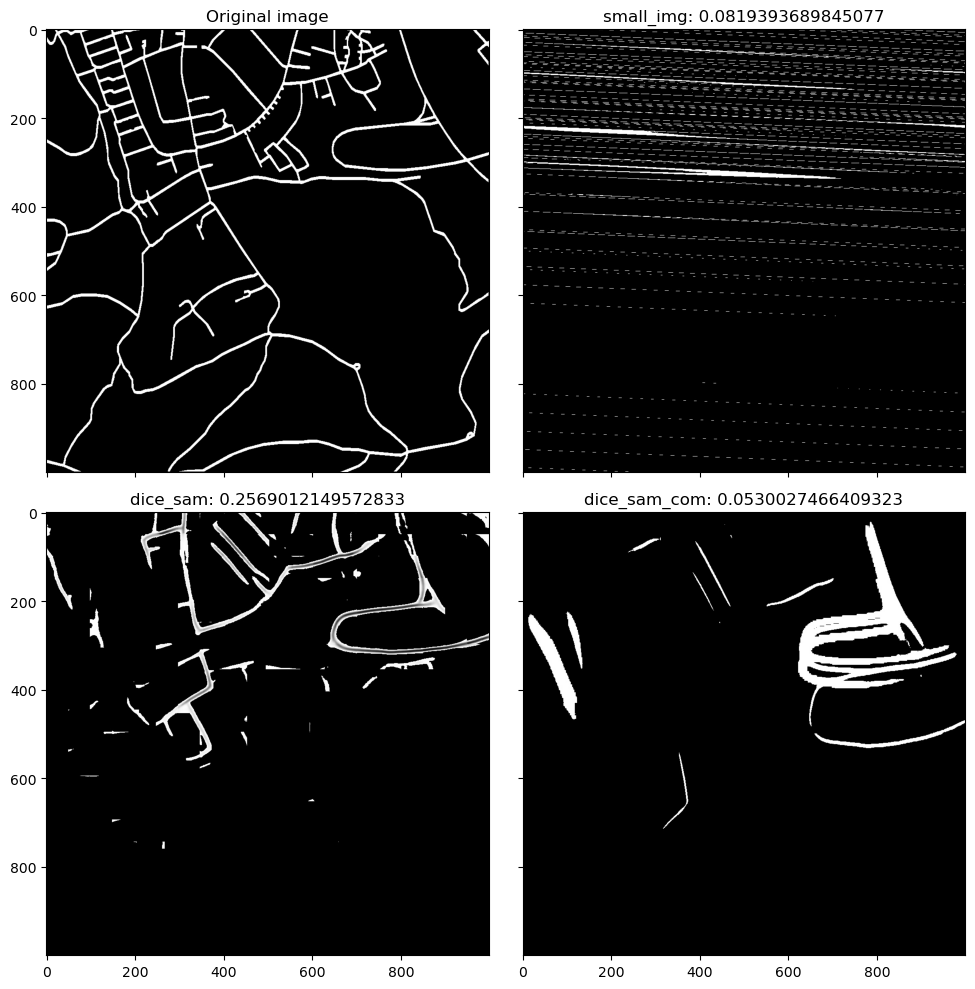

In [5]:
load_index = 1

img = cv2.imread('/goss/Datasets/'+df.loc[load_index]['image_path']) 
small_img = cv2.imread(df.loc[load_index]['small_path']) 
sam_img = cv2.imread(df.loc[load_index]['sam_path']) 
sam_combine_img = cv2.imread(df.loc[load_index]['sam_combine_path'])  
gt_img = cv2.imread(df.loc[load_index]['gt_path']) 

dice_small = df.loc[load_index]['dice_small']
dice_sam = df.loc[load_index]['dice_sam']
dice_sam_com = df.loc[load_index]['dice_sam_com']

fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(gt_img)
ax1.set_title('Original image')

ax2.imshow(small_img)
ax2.set_title('small_img: '+str(dice_small))

ax3.imshow(sam_img)
ax3.set_title('dice_sam: '+ str(dice_sam))

ax4.imshow(sam_combine_img)
ax4.set_title('dice_sam_com: '+str(dice_sam_com))

# for ax in ax_arr.ravel():
#     ax.set_axis_off()

plt.tight_layout()
plt.show()


In [ ]:
result_small = df.groupby('dataset')['dice_small'].agg(['mean', 'std'])
result_sam = df.groupby('dataset')['dice_sam'].agg(['mean', 'std'])
result_sam_com = df.groupby('dataset')['dice_sam_com'].agg(['mean', 'std'])


In [ ]:
result_small

In [ ]:
result_sam

In [ ]:
result_sam_com